In [17]:
%matplotlib inline

import os 
import json 

import boto3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from mirrorverse.utils import read_data_w_cache

os.environ['HAVEN_DATABASE'] = 'haven'
os.environ['AWS_PROFILE'] = 'admin'

COLOR_PALETTE = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

In [18]:
s3_client = boto3.client('s3')
bucket = 'mimic-log-odds-models'
prefix = 'movement-model-m3-a3-v12'

response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)

configs = {}
if 'Contents' in response:
    for obj in response['Contents']:
        if obj['Key'].endswith('config.json'):
            config = json.loads(s3_client.get_object(Bucket=bucket, Key=obj['Key'])['Body'].read().decode('utf-8'))
            if 'model' in config:
                configs[config['run_id']] = config['model']
else:
    print("No objects found.")

In [19]:
results = (
    read_data_w_cache('select * from movement_model_experiment_m3_a3_v12 ')
    .sort_values(['run_id', 'epoch'], ascending=True)
)
results.head()

,loss,val_loss,epoch,experiment_name,run_id
3500,0.547265,0.222627,1,movement-model-m3-a3-v12,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...
3501,0.289207,0.172653,2,movement-model-m3-a3-v12,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...
3502,0.248725,0.168798,3,movement-model-m3-a3-v12,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...
3503,0.236500,0.164835,4,movement-model-m3-a3-v12,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...
3504,0.232467,0.164992,5,movement-model-m3-a3-v12,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...


In [20]:
rows = []
for run_id, config in configs.items():
    rows.append({
        'run_id': run_id,
        'neurons': int(config['layers'][0][1:]),
        'dropout': 0.0 if not config['layers'][1].startswith('Dropout') else float(config['layers'][1][-1])/10
    })

configs_data = pd.DataFrame(rows)
configs_data.head()

,run_id,neurons,dropout
0,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,8,0.3
1,0a1eecf7b4bc4131da11ff9ada46802a6cb1aa97773a50...,16,0.2
2,1042d679d85b1263dff25144f3ac1dd201f741464955ff...,8,0.0
3,1999611940824648350a19b7530d3bc1da790b94eddd79...,24,0.0
4,32d49ea9c21928022a422da5bb54470c99d86230e30dc0...,24,0.2


In [21]:
results = results[['run_id', 'loss', 'val_loss', 'epoch']].merge(configs_data)
results.head()

,run_id,loss,val_loss,epoch,neurons,dropout
0,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,0.547265,0.222627,1,8,0.3
1,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,0.289207,0.172653,2,8,0.3
2,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,0.248725,0.168798,3,8,0.3
3,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,0.236500,0.164835,4,8,0.3
4,00c53a805980b861ffcf407d7243ae55d1bb55fb80ba6f...,0.232467,0.164992,5,8,0.3


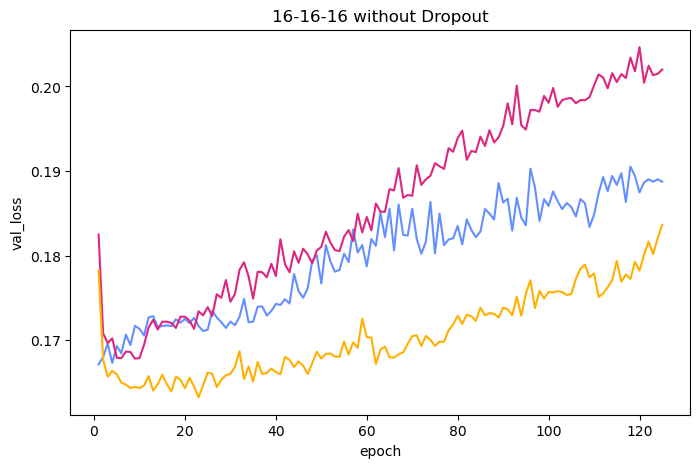

In [35]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 16) & (results['dropout'] == 0.0)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='val_loss', data=results[results['run_id'] == run_id], color=color)
plt.title("16-16-16 without Dropout");

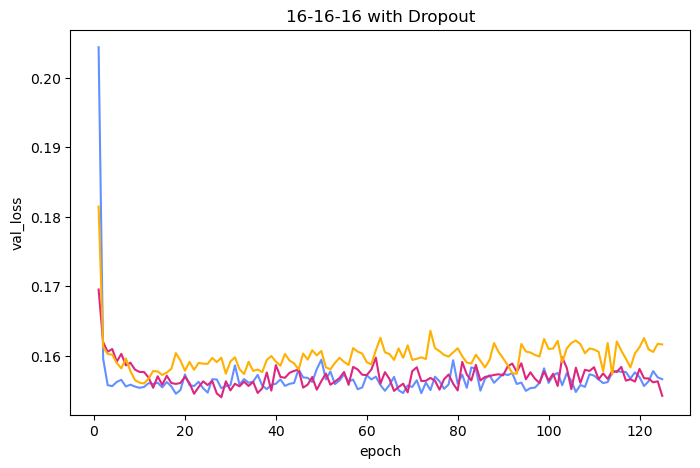

In [37]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 16) & (results['dropout'] > 0) & (results['epoch'] > 100)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='val_loss', data=results[results['run_id'] == run_id], color=color)
plt.title("16-16-16 with Dropout");

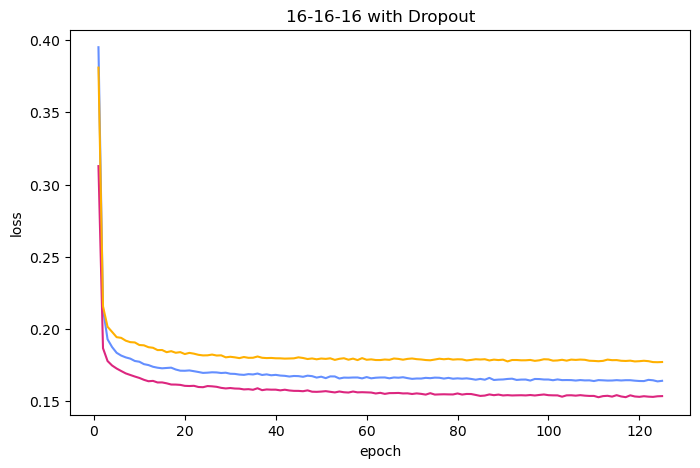

In [39]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 16) & (results['dropout'] > 0) & (results['epoch'] > 100)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='loss', data=results[results['run_id'] == run_id], color=color)
plt.title("16-16-16 with Dropout");

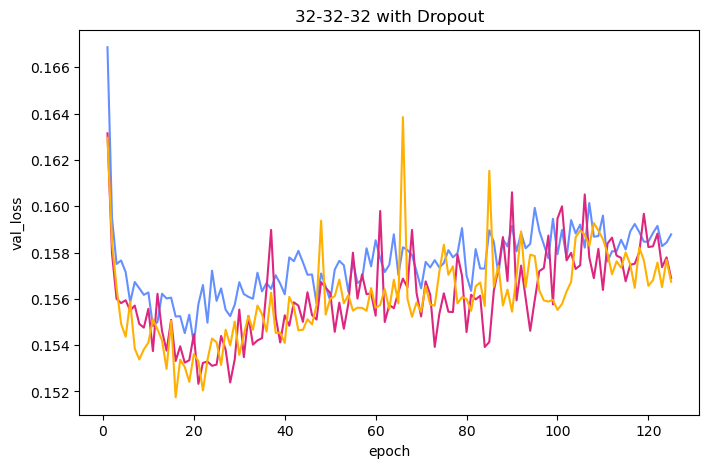

In [47]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 32) & (results['dropout'] >= 0.3)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='val_loss', data=results[results['run_id'] == run_id], color=color)
plt.title("32-32-32 with Dropout");

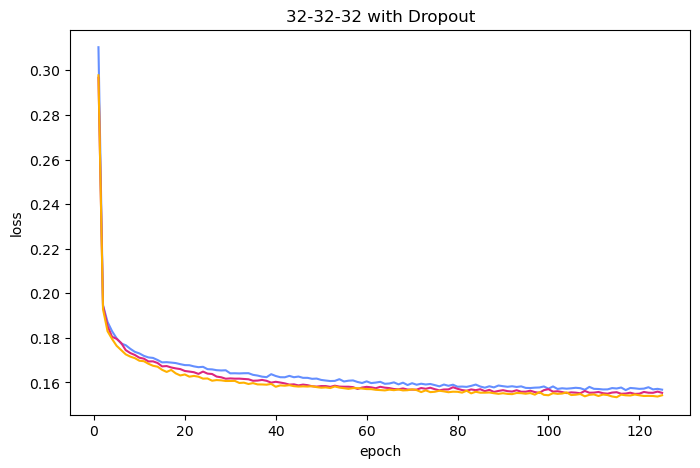

In [48]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 32) & (results['dropout'] >= 0.3)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='loss', data=results[results['run_id'] == run_id], color=color)
plt.title("32-32-32 with Dropout");

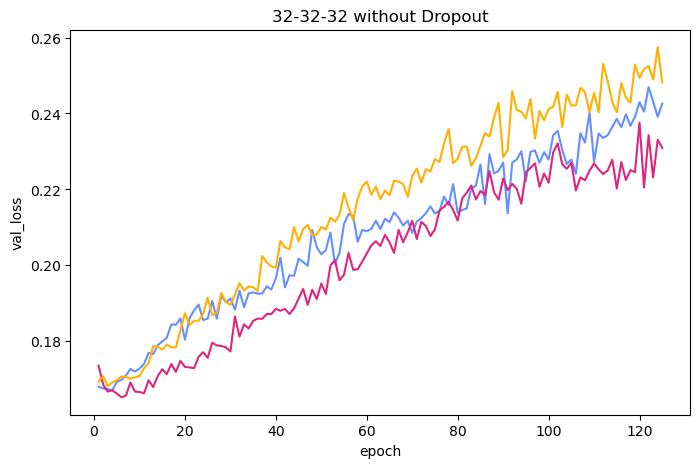

In [42]:
plt.figure(figsize=(8, 5))
run_ids = sorted(results[(results['neurons'] == 32) & (results['dropout'] == 0.0)]['run_id'].unique())
for run_id, color in zip(run_ids, COLOR_PALETTE[::2]):
    sns.lineplot(x='epoch', y='val_loss', data=results[results['run_id'] == run_id], color=color)
plt.title("32-32-32 without Dropout");

In [77]:
s3_client = boto3.client('s3')
bucket = 'mimic-log-odds-models'
version = 15
prefix = f'movement-model-m3-a3-v{version}'

response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)

configs = {}
if 'Contents' in response:
    for obj in response['Contents']:
        if obj['Key'].endswith('config.json'):
            config = json.loads(s3_client.get_object(Bucket=bucket, Key=obj['Key'])['Body'].read().decode('utf-8'))
            if 'model' in config:
                configs[config['run_id']] = config['model']
else:
    print("No objects found.")

rows = []
for run_id, config in configs.items():
    rows.append({
        'run_id': run_id,
        'neurons': int(config['layers'][0][1:]),
        'dropout': 0.0 if not config['layers'][1].startswith('Dropout') else float(config['layers'][1][-1])/10
    })

configs_data = pd.DataFrame(rows)

results = (
    read_data_w_cache(f'select * from movement_model_experiment_m3_a3_v{version}')
    .sort_values(['run_id', 'epoch'], ascending=True)
)
results = results[['run_id', 'loss', 'val_loss', 'epoch']].merge(configs_data)
results.head()

,run_id,loss,val_loss,epoch,neurons,dropout
0,13cba685d3daaefc3d292280404292632013ab66bc9d27...,0.442658,0.183378,1,48,0.6
1,13cba685d3daaefc3d292280404292632013ab66bc9d27...,0.231602,0.166509,2,48,0.6
2,13cba685d3daaefc3d292280404292632013ab66bc9d27...,0.213204,0.167998,3,48,0.6
3,13cba685d3daaefc3d292280404292632013ab66bc9d27...,0.208311,0.163980,4,48,0.6
4,13cba685d3daaefc3d292280404292632013ab66bc9d27...,0.205308,0.165078,5,48,0.6


In [78]:
final = results.groupby('run_id')[['val_loss', 'loss', 'epoch', 'neurons', 'dropout']].last().reset_index().sort_values('val_loss', ascending=True)
#final = final[final['epoch'] < 100]
final.head()

,run_id,val_loss,loss,epoch,neurons,dropout
18,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.160919,0.178113,50,32,0.5
9,881054172e15d9e23d80e396a299ad7e60df122bcde24a...,0.161086,0.163256,50,32,0.4
5,35d0b66c386b350e018447b9eced8df8bac4a944164473...,0.162657,0.178472,50,48,0.6
3,287e63a1772ca4102ae0e937c100cb1f0ac53b967edae7...,0.163356,0.152735,50,32,0.3
12,b3d15dc008feef0af2d35b6f88d0beef3ad6880ee5547d...,0.164934,0.179999,50,32,0.5


35d0b66c386b350e018447b9eced8df8bac4a944164473fba17c42718aaa68fa


<Axes: xlabel='epoch', ylabel='loss'>

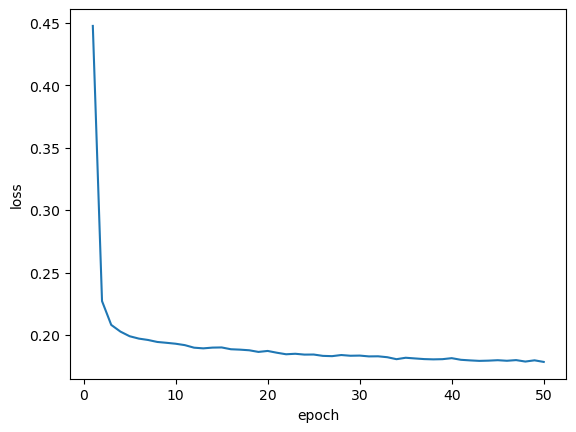

In [85]:
run_id = final[final['neurons'] == 48]['run_id'].values[0]
print(run_id)

sns.lineplot(
    results[results['run_id'] == run_id], x='epoch', y='loss'
)

In [83]:
results[results['run_id'] == run_id]

,run_id,loss,val_loss,epoch,neurons,dropout
900,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.421167,0.190919,1,32,0.5
901,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.226104,0.158690,2,32,0.5
902,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.207663,0.158560,3,32,0.5
903,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.201567,0.158624,4,32,0.5
904,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.197589,0.158320,5,32,0.5
905,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.194878,0.159690,6,32,0.5
906,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.191912,0.156445,7,32,0.5
907,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.191114,0.158237,8,32,0.5
908,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.189950,0.158731,9,32,0.5
909,f96c25b133ac75b386e8e6505652ebca431d0804b8fb6c...,0.187773,0.155970,10,32,0.5
